# 引入包

In [1]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  numpy
import random
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import  Dataset,random_split,DataLoader
from numpy import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# 超参数

In [2]:
batch_size = 158
lr = 0.001
epoch_num = 50
num_work = 2

# 加载数据集合

In [3]:
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):

        self.data_path = data_path
        self.transform = transform
        self.label_folder = os.listdir(self.data_path)
        self.file = []
        for str in self.label_folder:
            st = os.path.join(self.data_path, str)
            my = os.listdir(st)
            random.shuffle(my)
            t = my[int(len(my) * 0.7):]
            if train:
                t = my[:int(len(my) * 0.7)]

            for index in t:
                self.file.append(os.path.join(st, index))

    def __len__(self):
        return len(self.file)

    def __getitem__(self, idx):

        # 读取图像和标签文件
        image = Image.open(self.file[idx])
        label = os.path.split(os.path.dirname(self.file[idx]))[-1]
        # 数据转换
        if self.transform:
            image = self.transform(image)

        return image, torch.eye(3)[self.label_folder.index(label)]


transform = transforms.Compose([
    transforms.Resize((80, 80)),

    transforms.ToTensor(),
])

# 创建自定义数据集
TrainDataset = MyDataset(data_path=r'/kaggle/input/expersion03/train',
                         transform=transform
                         , train=True)
TestDataset = MyDataset(data_path=r'/kaggle/input/expersion03/train',
                        transform=transform
                        , train=False)
print(TrainDataset.__len__(), TestDataset.__len__())

948 409


# 定义网络

In [8]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=0
                      ,dilation=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=0,
                      dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0,
                      dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        out = self.conv(x)
        out = nn.functional.avg_pool2d(out, 32)
        out = out.squeeze()
        out = self.fc(out.view(batch_size, -1))
        out = F.softmax(out, dim=1)
        return out

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=0
                      ,dilation=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=0,
                      dilation=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0,
                      dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        out = self.conv(x)
        out = nn.functional.avg_pool2d(out, 32)
        out = out.squeeze()
        out = self.fc(out.view(batch_size, -1))
        out = F.softmax(out, dim=1)
        return out
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=0
                      ,dilation=5
                      ),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=0,
                      dilation=5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0,
                      dilation=5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        out = self.conv(x)
        out = nn.functional.avg_pool2d(out, 32)
        out = out.squeeze()
        out = self.fc(out.view(batch_size, -1))
        out = F.softmax(out, dim=1)
        return out

train_loader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=True,num_workers=num_work)
test_loader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False,num_workers=num_work)
loss = nn.CrossEntropyLoss()

# 训练与超参数

In [5]:
import time
train_loss_0=[]
train_acc_0=[]
test_loss_0=[]
test_acc_0=[]

net = Net().to(device)
opt = torch.optim.Adam(net.parameters(), lr=lr)
start_time = time.time()
for epoch in range(epoch_num):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for x, y in train_loader:
        y_hat = net(x.to(device))
        l = loss(y_hat.view(-1), y.view(-1).to(device))
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        train_acc_list.append(acc/len(y_index))
        opt.zero_grad()
        l.backward()
        train_loss_list.append(l.item())
        opt.step()

    for x, y in test_loader:

        if(x.size()[0]<batch_size):
            continue
        y_hat = net(x.to(device))

        l = loss(y_hat.view(-1), y.view(-1).to(device))
        # print(l)
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        test_acc_list.append(acc/len(y_index))
        test_loss_list.append(l.item())
        # print("done")
    train_loss_mean = numpy.mean(train_loss_list)
    train_acc_mean=numpy.mean(train_acc_list)
    train_loss_0.append(train_loss_mean)
    train_acc_0.append(train_acc_mean)
    test_loss_mean=numpy.mean(test_loss_list)
    test_acc_mean=numpy.mean(test_acc_list)

    test_loss_0.append(test_loss_mean)
    test_acc_0.append(test_acc_mean)
    print("epoch:",epoch+1,
          "\n",
          "train_loss:",train_loss_mean,'train_acc',train_acc_mean,
           "\n",
          "test_loss:", test_loss_mean, 'test_acc',test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 952.2311808268229 train_acc 0.6772151898734178 
 test_loss: 955.9188537597656 test_acc 0.5443037974683544
epoch: 2 
 train_loss: 934.8561299641927 train_acc 0.7457805907172995 
 test_loss: 949.8269348144531 test_acc 0.5981012658227848
epoch: 3 
 train_loss: 927.0865376790365 train_acc 0.7879746835443037 
 test_loss: 945.5265808105469 test_acc 0.6424050632911392
epoch: 4 
 train_loss: 922.5693868001302 train_acc 0.809071729957806 
 test_loss: 941.1913452148438 test_acc 0.6835443037974683
epoch: 5 
 train_loss: 918.8790893554688 train_acc 0.8354430379746836 
 test_loss: 937.8705139160156 test_acc 0.7056962025316456
epoch: 6 
 train_loss: 917.0302429199219 train_acc 0.8386075949367089 
 test_loss: 936.5218505859375 test_acc 0.689873417721519
epoch: 7 
 train_loss: 915.0769246419271 train_acc 0.8470464135021097 
 test_loss: 933.4682006835938 test_acc 0.7183544303797469
epoch: 8 
 train_loss: 913.445302327474 train_acc 0.8565400843881856 
 test_loss: 931.9541931152344

In [6]:
import time
train_loss_1=[]
train_acc_1=[]
test_loss_1=[]
test_acc_1=[]

net = Net1().to(device)
opt = torch.optim.Adam(net.parameters(), lr=lr)
start_time = time.time()
for epoch in range(epoch_num):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for x, y in train_loader:
        y_hat = net(x.to(device))
        l = loss(y_hat.view(-1), y.view(-1).to(device))
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        train_acc_list.append(acc/len(y_index))
        opt.zero_grad()
        l.backward()
        train_loss_list.append(l.item())
        opt.step()

    for x, y in test_loader:

        if(x.size()[0]<batch_size):
            continue
        y_hat = net(x.to(device))

        l = loss(y_hat.view(-1), y.view(-1).to(device))
        # print(l)
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        test_acc_list.append(acc/len(y_index))
        test_loss_list.append(l.item())
        # print("done")
    train_loss_mean = numpy.mean(train_loss_list)
    train_acc_mean=numpy.mean(train_acc_list)
    train_loss_1.append(train_loss_mean)
    train_acc_1.append(train_acc_mean)
    test_loss_mean=numpy.mean(test_loss_list)
    test_acc_mean=numpy.mean(test_acc_list)

    test_loss_1.append(test_loss_mean)
    test_acc_1.append(test_acc_mean)
    print("epoch:",epoch+1,
          "\n",
          "train_loss:",train_loss_mean,'train_acc',train_acc_mean,
           "\n",
          "test_loss:", test_loss_mean, 'test_acc',test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 960.5073750813802 train_acc 0.5369198312236287 
 test_loss: 958.0945129394531 test_acc 0.5221518987341772
epoch: 2 
 train_loss: 937.5589396158854 train_acc 0.7289029535864979 
 test_loss: 952.0277404785156 test_acc 0.560126582278481
epoch: 3 
 train_loss: 928.6292521158854 train_acc 0.7985232067510549 
 test_loss: 947.6645812988281 test_acc 0.6075949367088608
epoch: 4 
 train_loss: 922.8822937011719 train_acc 0.8312236286919831 
 test_loss: 944.0487365722656 test_acc 0.6613924050632911
epoch: 5 
 train_loss: 918.707275390625 train_acc 0.839662447257384 
 test_loss: 940.6376953125 test_acc 0.6835443037974683
epoch: 6 
 train_loss: 916.0193176269531 train_acc 0.8438818565400844 
 test_loss: 938.275390625 test_acc 0.6867088607594937
epoch: 7 
 train_loss: 913.8703104654948 train_acc 0.8523206751054854 
 test_loss: 936.67529296875 test_acc 0.6867088607594937
epoch: 8 
 train_loss: 912.7080485026041 train_acc 0.8554852320675105 
 test_loss: 935.529296875 test_acc 0.6

In [9]:
import time
train_loss_2=[]
train_acc_2=[]
test_loss_2=[]
test_acc_2=[]

net = Net2().to(device)
opt = torch.optim.Adam(net.parameters(), lr=lr)
start_time = time.time()
for epoch in range(epoch_num):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for x, y in train_loader:
        y_hat = net(x.to(device))
        l = loss(y_hat.view(-1), y.view(-1).to(device))
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        train_acc_list.append(acc/len(y_index))
        opt.zero_grad()
        l.backward()
        train_loss_list.append(l.item())
        opt.step()

    for x, y in test_loader:

        if(x.size()[0]<batch_size):
            continue
        y_hat = net(x.to(device))

        l = loss(y_hat.view(-1), y.view(-1).to(device))
        # print(l)
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        test_acc_list.append(acc/len(y_index))
        test_loss_list.append(l.item())
        # print("done")
    train_loss_mean = numpy.mean(train_loss_list)
    train_acc_mean=numpy.mean(train_acc_list)
    train_loss_2.append(train_loss_mean)
    train_acc_2.append(train_acc_mean)
    test_loss_mean=numpy.mean(test_loss_list)
    test_acc_mean=numpy.mean(test_acc_list)

    test_loss_2.append(test_loss_mean)
    test_acc_2.append(test_acc_mean)
    print("epoch:",epoch+1,
          "\n",
          "train_loss:",train_loss_mean,'train_acc',train_acc_mean,
           "\n",
          "test_loss:", test_loss_mean, 'test_acc',test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 965.4561157226562 train_acc 0.5327004219409283 
 test_loss: 959.2240600585938 test_acc 0.5443037974683544
epoch: 2 
 train_loss: 941.5684407552084 train_acc 0.7573839662447259 
 test_loss: 951.4591979980469 test_acc 0.620253164556962
epoch: 3 
 train_loss: 930.064208984375 train_acc 0.7985232067510548 
 test_loss: 946.1071472167969 test_acc 0.6550632911392406
epoch: 4 
 train_loss: 923.2646687825521 train_acc 0.8259493670886076 
 test_loss: 941.3299560546875 test_acc 0.6835443037974684
epoch: 5 
 train_loss: 918.3441060384115 train_acc 0.8375527426160337 
 test_loss: 937.5228271484375 test_acc 0.6867088607594937
epoch: 6 
 train_loss: 914.7925313313802 train_acc 0.8523206751054854 
 test_loss: 933.4234619140625 test_acc 0.7056962025316456
epoch: 7 
 train_loss: 912.710205078125 train_acc 0.8628691983122363 
 test_loss: 930.9809875488281 test_acc 0.7215189873417722
epoch: 8 
 train_loss: 910.6982014973959 train_acc 0.8702531645569621 
 test_loss: 929.5410461425781

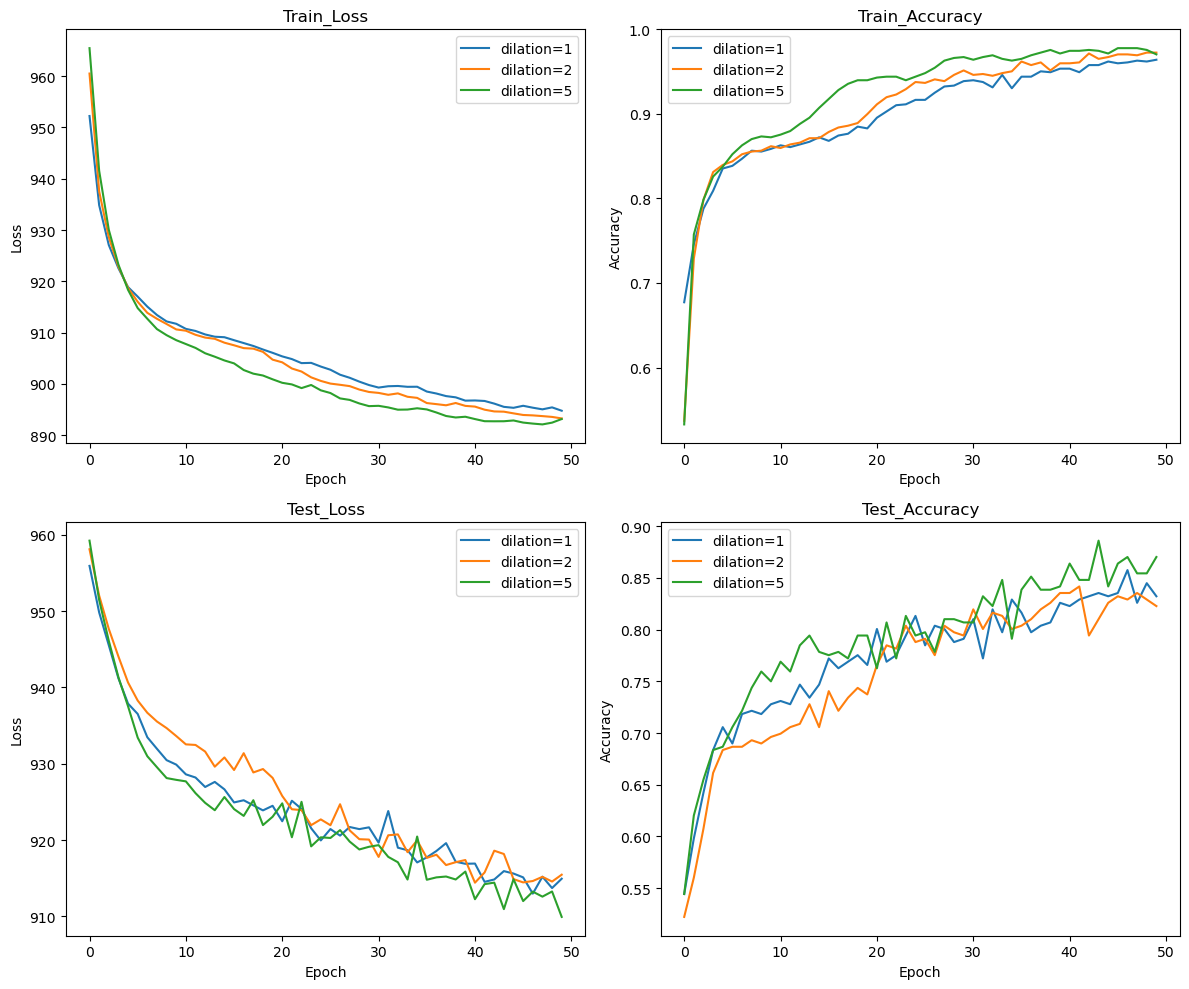

In [10]:
from matplotlib import pyplot as plt

# 示例数据
train_loss = [train_loss_0, train_loss_1, train_loss_2]
test_loss = [test_loss_0, test_loss_1, test_loss_2]
train_acc = [train_acc_0, train_acc_1, train_acc_2]
test_acc = [test_acc_0, test_acc_1, test_acc_2]
titles_loss = ['Train_Loss', 'Test_Loss']
titles_acc = ['Train_Accuracy', 'Test_Accuracy']
labels = ['dilation=1', 'dilation=2', 'dilation=5']

# 创建2x2的图，并添加脚标
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 绘制Train_Loss和Test_Loss
for i in range(3):
    ax_train_loss = axes[0, 0]
    ax_train_loss.plot(train_loss[i], label=f'{labels[i]}')

    ax_test_loss = axes[1, 0]
    ax_test_loss.plot(test_loss[i], label=f'{labels[i]}')

# 绘制Train_Accuracy和Test_Accuracy
for i in range(3):
    ax_train_acc = axes[0, 1]
    ax_train_acc.plot(train_acc[i], label=f'{labels[i]}')

    ax_test_acc = axes[1, 1]
    ax_test_acc.plot(test_acc[i], label=f'{labels[i]}')

# 设置标题和标签
for ax in axes.flat:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss' if ax in [axes[0, 0], axes[1, 0]] else 'Accuracy')

axes[0, 0].set_title(titles_loss[0])
axes[0, 0].legend()

axes[1, 0].set_title(titles_loss[1])
axes[1, 0].legend()

axes[0, 1].set_title(titles_acc[0])
axes[0, 1].legend()

axes[1, 1].set_title(titles_acc[1])
axes[1, 1].legend()

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
